# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

"""
IPython имеет набор «волшебных функций», которые можно вызывать 
с помощью синтаксиса стиля командной строки. Есть два вида магии: линейно-ориентированная и клеточно-ориентированная. 
Магия строк начинается с символа% и работает так же, как вызовы командной строки ОС: 
они получают в качестве аргумента остальную часть строки, 
где аргументы передаются без скобок или кавычек. 
Магия линий может возвращать результаты и может использоваться в правой части задания. 
Клеточная магия имеет двойной префикс %%, и это функции, которые получают 
в качестве аргумента не только остальную часть строки, но и строки под ней в отдельном аргументе.

%matplotlib inline устанавливает бэкэнд matplotlib на 'встроенный' бэкэнд.
С помощью этого бэкэнда вывод команд построения графиков отображается внутри внешних интерфейсов, 
как в записной книжке Jupyter, непосредственно под ячейкой кода, которая его создала. 
Полученные графики также будут сохранены в документе записной книжки
Подробнее: https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline 
"""

warnings.filterwarnings('ignore')

In [2]:
data_geo = pd.read_excel('geo.xlsx')
data_geo

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1
...,...,...,...,...
108801,108801,37.454528,55.792331,-1
108802,108802,37.384325,55.899068,-1
108803,108803,37.421066,55.848756,1
108804,108804,37.448509,55.793065,-1


In [3]:
data_geo_comment = pd.read_excel('geo_comment.xlsx')
print(data_geo_comment.comment.nunique())
data_geo_comment

7335


,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...
...,...,...,...,...,...,...
70377,70377,37.454528,55.792331,-1,1,Не поддерживаю. Я против строительства многоэт...
70378,70378,37.384325,55.899068,-1,1,Не поддерживаю. Не нужны отстойники автобусов ...
70379,70379,37.421066,55.848756,1,1,"Не поддерживаю. На мой взгляд, необходимо искл..."
70380,70380,37.448509,55.793065,-1,1,Не поддерживаю: нарушения при строительстве н...


In [4]:
"""
1) визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
"""

# разделим комментарии на 2 части: за и против 

comment_positive = data_geo[data_geo['comment_class']==1]
print(len(comment_positive))
comment_negative = data_geo[data_geo['comment_class']==-1]
print(len(comment_negative))

13659
95147


In [5]:
# проверим, есть ли среди полученных датасетов пустые строки 
# как видим из ниже приведенного кода, пустые значения отсутствуют

print(comment_positive.info())
print(comment_negative.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13659 entries, 28 to 108803
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     13659 non-null  int64  
 1   x              13659 non-null  float64
 2   y              13659 non-null  float64
 3   comment_class  13659 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 533.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 95147 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     95147 non-null  int64  
 1   x              95147 non-null  float64
 2   y              95147 non-null  float64
 3   comment_class  95147 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.6 MB
None


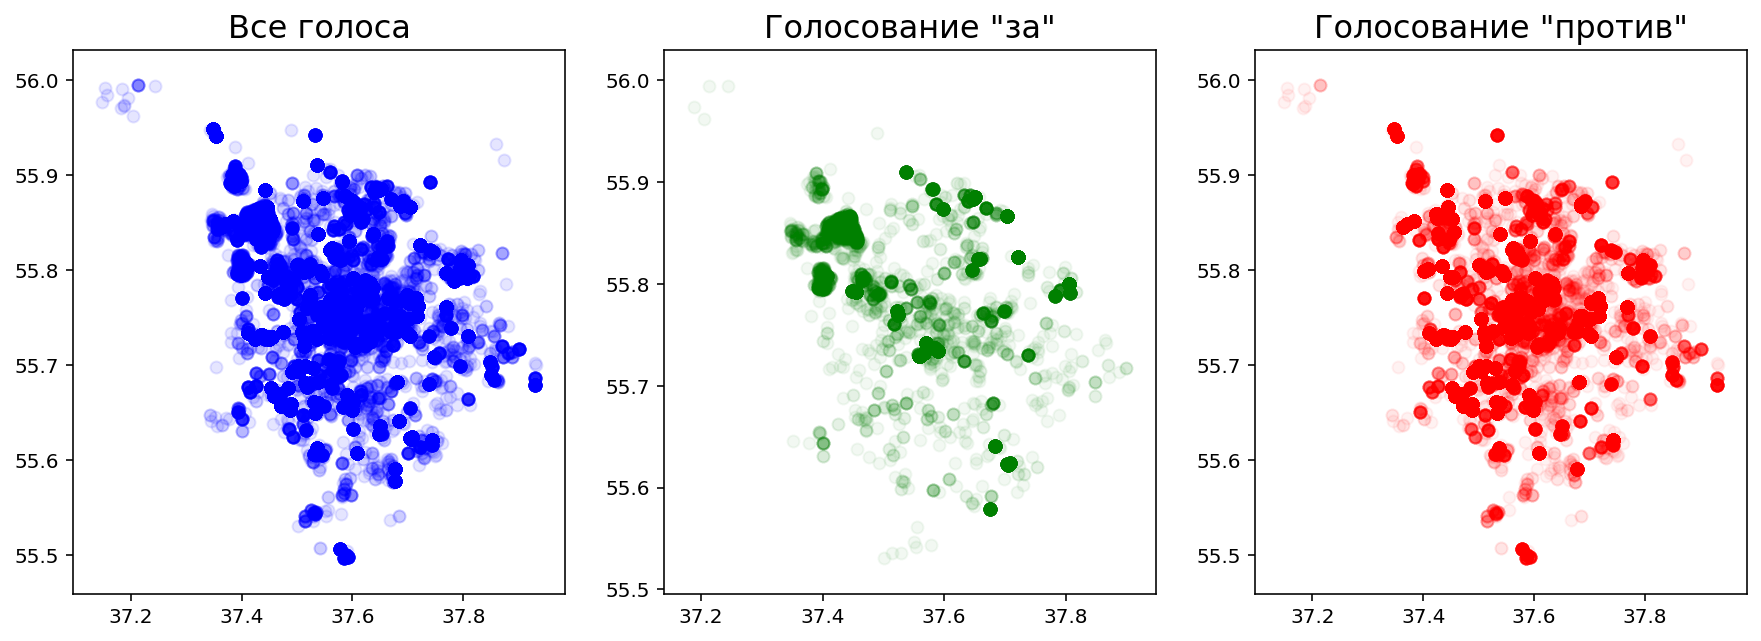

In [6]:
# видим, что количество голосов "за" значительно уступает количесту голосов "против"
# представим это отношение визуально: на графике изобразим плотность положительных и отрицательных голосов 
# Заодно сформируем график всех голосов, зафиксированных в датафрейме 
    
rcParams['figure.figsize'] = (9, 15)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))           # количество строк, столбцов, размер 

ax1.scatter(x=data_geo.x, y=data_geo.y, alpha=0.1, color='b')
ax2.scatter(x=comment_positive.x, y=comment_positive.y, alpha=0.05, color='g')
ax3.scatter(x=comment_negative.x, y=comment_negative.y, alpha=0.05, color='r')

titles = ['Все голоса', 'Голосование "за"', 'Голосование "против"']

for pic, title in zip (fig.axes, titles):
    pic.set_title(title, fontsize=16)

In [7]:
# фактически на графике "Все голоса" мы изобразили городскую карту безотносительно характериа голосования - за или против
# теперь вычленим районы (административные округа) Москвы сообразно имеющимся данным о голосовании на публичных случаниях
# поскольку в столице до расширения города было 10 АО, количество кластеров создадим, равным 10-ти 

# воспользуемся методом К-средних 
# так как нам не требуется разбивать районы в соответствии с уровнем положительного/протестного голосования,
# то избавимся от столбца, сигнализирующего о данном критерии.
# Таким образом, в кластеризации будут участовать только данные, которые обеспечивают географическую привзяку 

data_geo_without_votes = data_geo.drop('comment_class', axis=1)
clf_kmeans = KMeans(n_clusters=10, max_iter=400, random_state=42)

In [8]:
# обучим модель 
clusters = clf_kmeans.fit_predict(data_geo_without_votes)

In [9]:
for clus in range(10):
    print (clus, 'кластер - ', len(data_geo_without_votes[clusters==clus]))

0 кластер -  10867
1 кластер -  10816
2 кластер -  10830
3 кластер -  11073
4 кластер -  10917
5 кластер -  10768
6 кластер -  10866
7 кластер -  10867
8 кластер -  10893
9 кластер -  10909


In [10]:
# теперь попробуем применить другой метод разбиения на кластеры - 
# подсчитаем с учетом метода инерции (.inertia_) оптимальное количество кластеров

k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_geo_without_votes)
    k_inertia.append(clf_kmeans.inertia_)

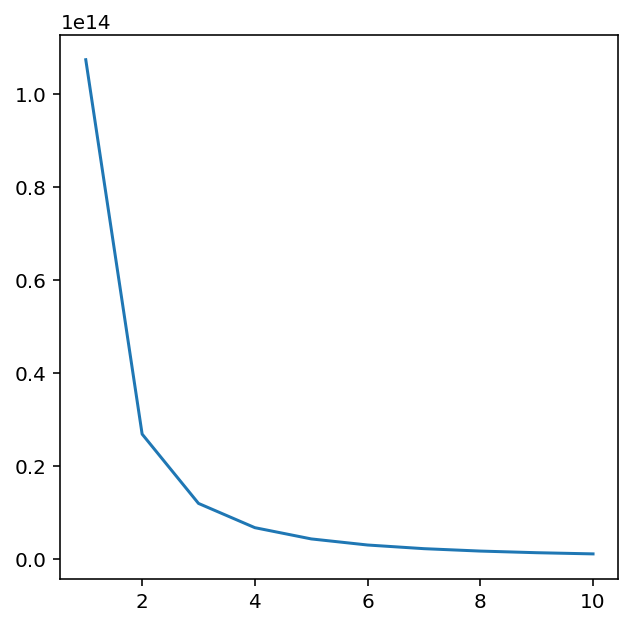

In [27]:
rcParams['figure.figsize'] = (5, 5)
plt.plot(ks, k_inertia)

In [12]:
# примерно видно, что после 5 (или даже 4-го) кластера изменения незначительны, потому 4-5 кластеров было бы достаточно
# подтвердим это математически. Для этого воспользуемся формулой оптимального количества

# по написанию формул в LaTeX:
# https://en.wikibooks.org/wiki/LaTeX/Mathematics
# https://detexify.kirelabs.org/classify.html 


$$k_{opt} = argmin(\frac{iteria_{k+1}-iteria_k}{iteria_k-iteria_{k-1}})$$

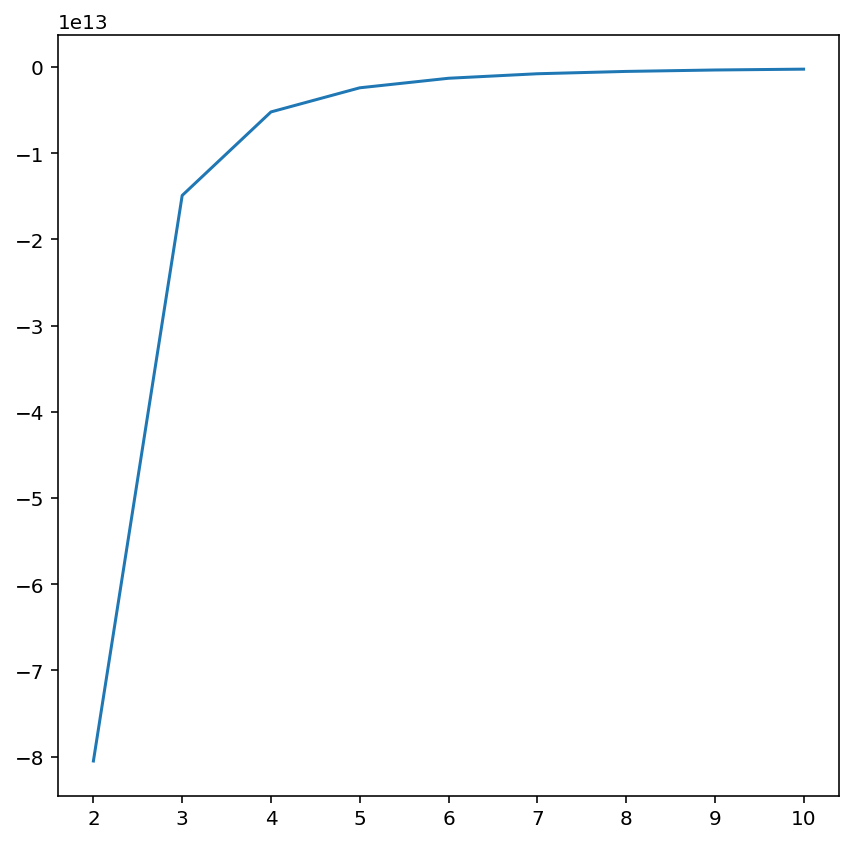

In [25]:
diff=np.diff(k_inertia)  # функция возвращает n-ю разность элементов массива, 
                         # которая также может быть вычислена вдоль указанной оси (осей)
rcParams['figure.figsize'] = (7, 7)
plt.plot(ks[1:], diff)

In [14]:
# применим формулу
diff_r = diff[1:] / diff[:-1]

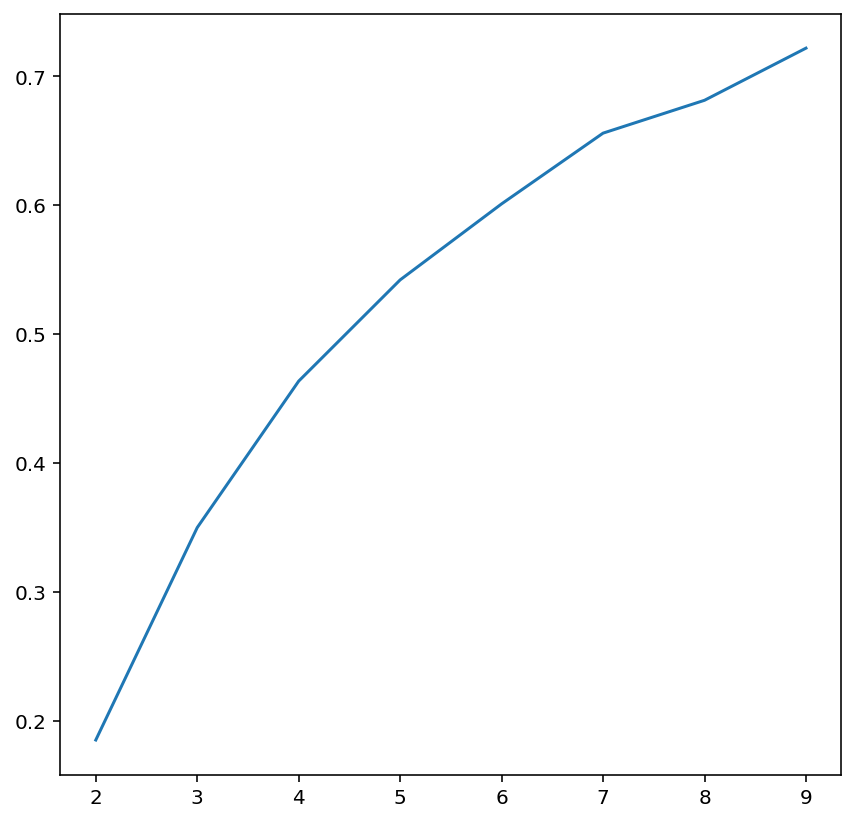

In [23]:
rcParams['figure.figsize'] = (7, 7)
plt.plot(ks[1:-1], diff_r)

In [16]:
k_opt = ks[np.argmin(diff_r)+1]   # функция возвращает индекс минимального значения вдоль указанной оси
k_opt

2

In [20]:
# финализируем наши исследования

clf_kmeans_end = KMeans(n_clusters=2, max_iter=400, random_state=43)
# обучим модель 
clusters_ = clf_kmeans_end.fit_predict(data_geo_without_votes)
for clus in range(2):
    print (clus, 'кластер - ', len(data_geo_without_votes[clusters_==clus]))

0 кластер -  54470
1 кластер -  54336


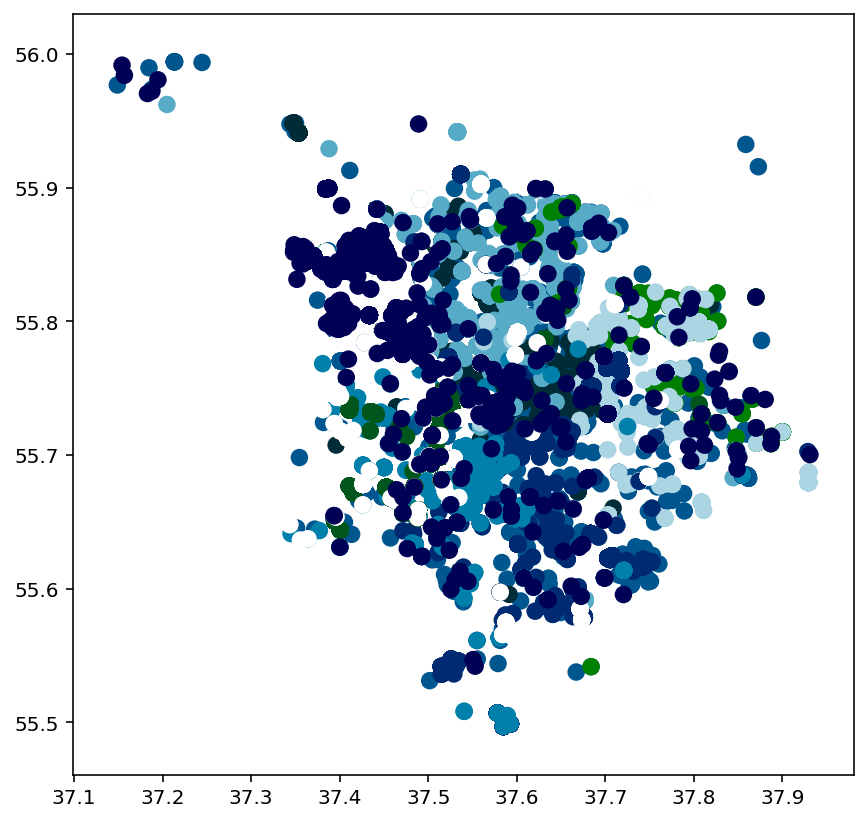

In [29]:
# визуализируем результат. 
# Примем первоначальное разделение по кластерам

rcParams['figure.figsize'] = (7, 7)
plt.scatter(data_geo_without_votes.x, data_geo_without_votes.y, c=clusters, cmap='ocean', s=60) 

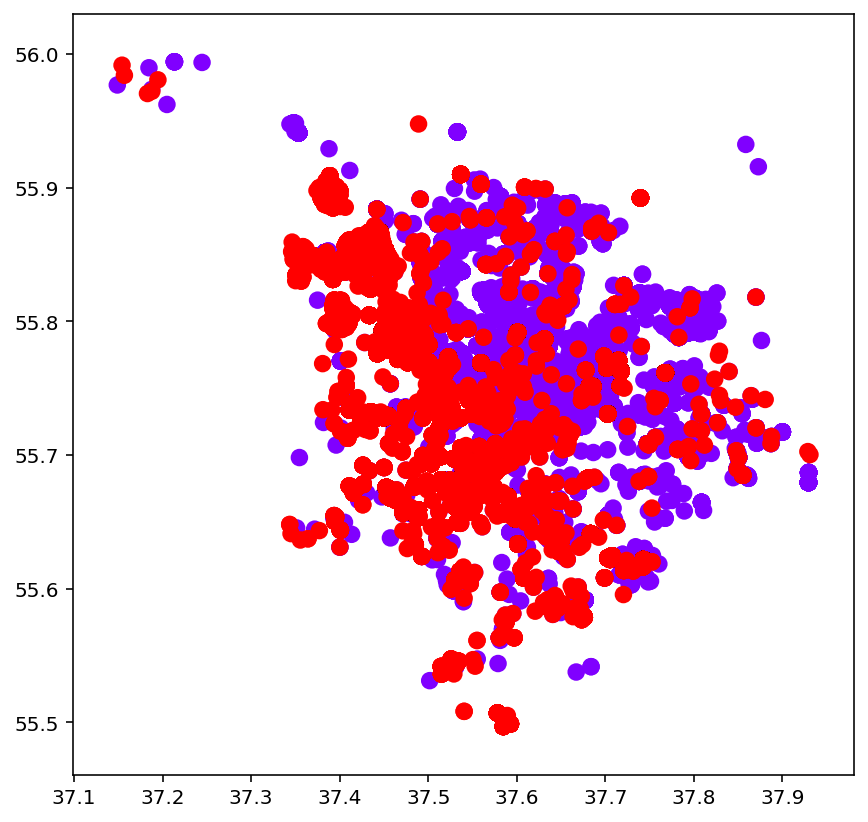

In [33]:
# визуализируем результат. 
# Примем первоначальное разделение по кластерам

rcParams['figure.figsize'] = (7, 7)
plt.scatter(data_geo_without_votes.x, data_geo_without_votes.y, c=clusters_, cmap='rainbow', s=60)

# цветовая карта графика: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

In [22]:
# как видим, обучение модели дает лучший результат, если придерживаться 
# полученной в результате расчетов рекомендации делить на 2 кластера

In [34]:
"""
2) аналогично исследовать скопления голосов за и против отдельно
"""

# чтобы реализовать тот же алгоритм кластеризации, но по группам (положительное/отрицательное голосование) в отдельности, 
# вначале удалим столбец класса комментариев 

comment_positive_without_votes = comment_positive.drop('comment_class', axis=1)
comment_negative_without_votes = comment_negative.drop('comment_class', axis=1)
# clf_kmeans = KMeans(n_clusters=10, max_iter=400, random_state=42)


In [35]:
dbscan_ = DBSCAN(eps=0.05, min_samples=1000) # eps - размер окрестности, min_samples - кол-во точек в окретсности ядра 


In [45]:
dbscan_clust = dbscan_.fit_predict(comment_positive_without_votes)

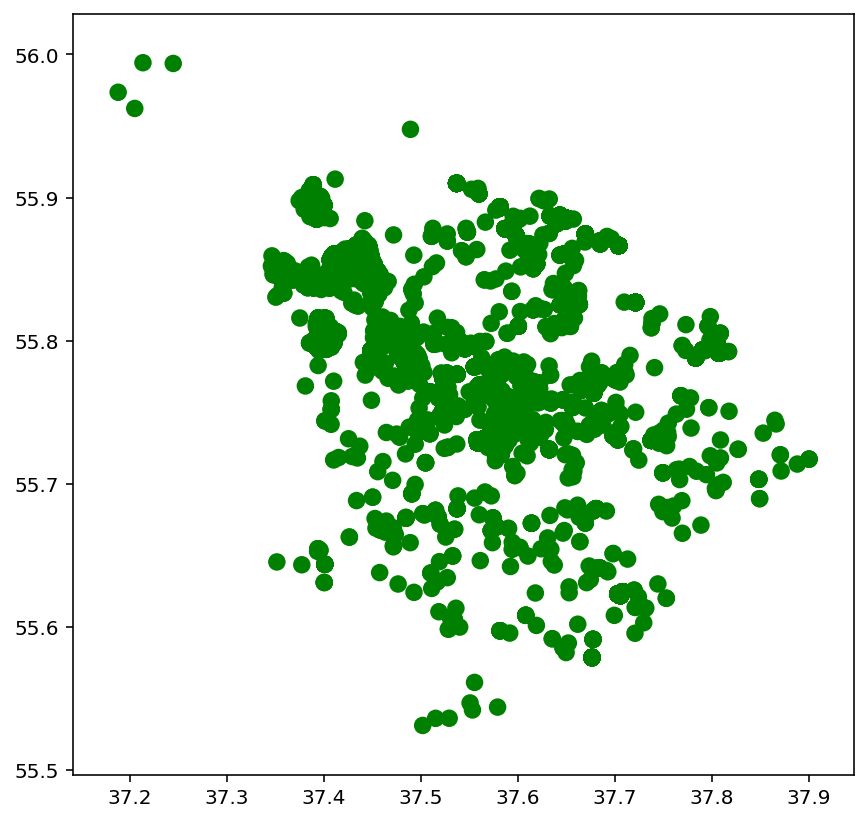

In [38]:
# визуализируем результат по положительным комментариям 
# метод явно не для нашего случая - он разбивает всего на 1 кластер

rcParams['figure.figsize'] = (7, 7)
plt.scatter(comment_positive_without_votes.x, comment_positive_without_votes.y, c=dbscan_clust, cmap='ocean', s=60) 

In [46]:
# применим снова метод К-средних
# сначала для положительных комментариев 
kmeans = KMeans(n_clusters=5)
kmeans.fit(comment_positive_without_votes)
n_positive_clust = kmeans.predict(comment_positive_without_votes)

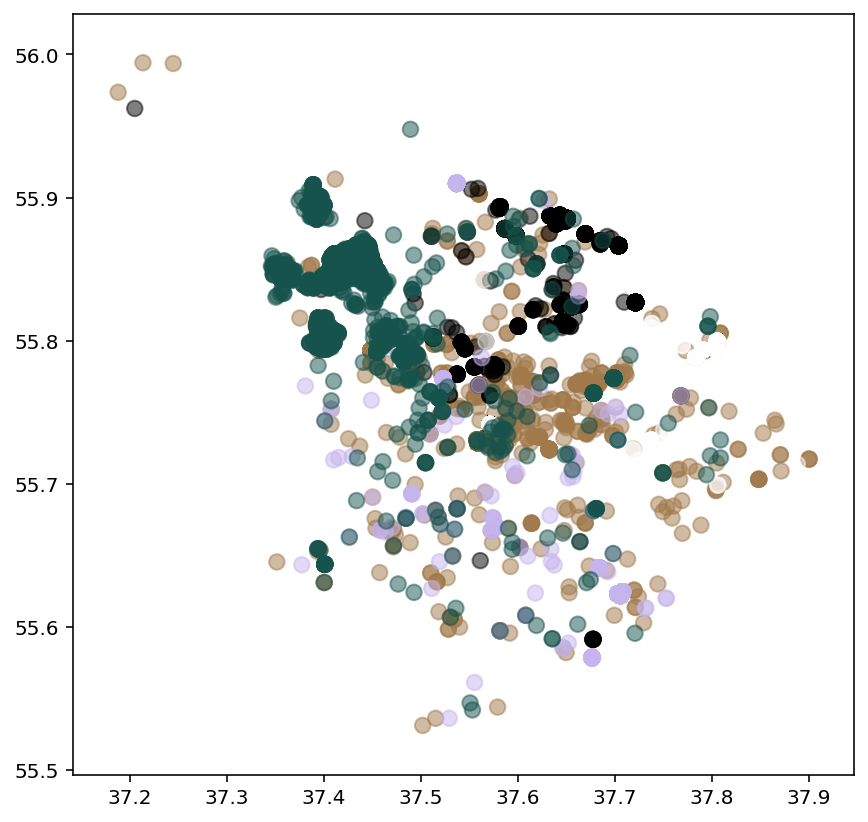

In [48]:
rcParams['figure.figsize'] = (7,7)
    
plt.scatter(comment_positive_without_votes.x, comment_positive_without_votes.y, c=n_positive_clust, alpha=0.5, cmap='cubehelix', s=60)

In [49]:
# далее применим тот же метод для кластеризации отрицательных комментариев 

kmeans = KMeans(n_clusters=5)
kmeans.fit(comment_negative_without_votes)
n_negative_clust = kmeans.predict(comment_negative_without_votes)

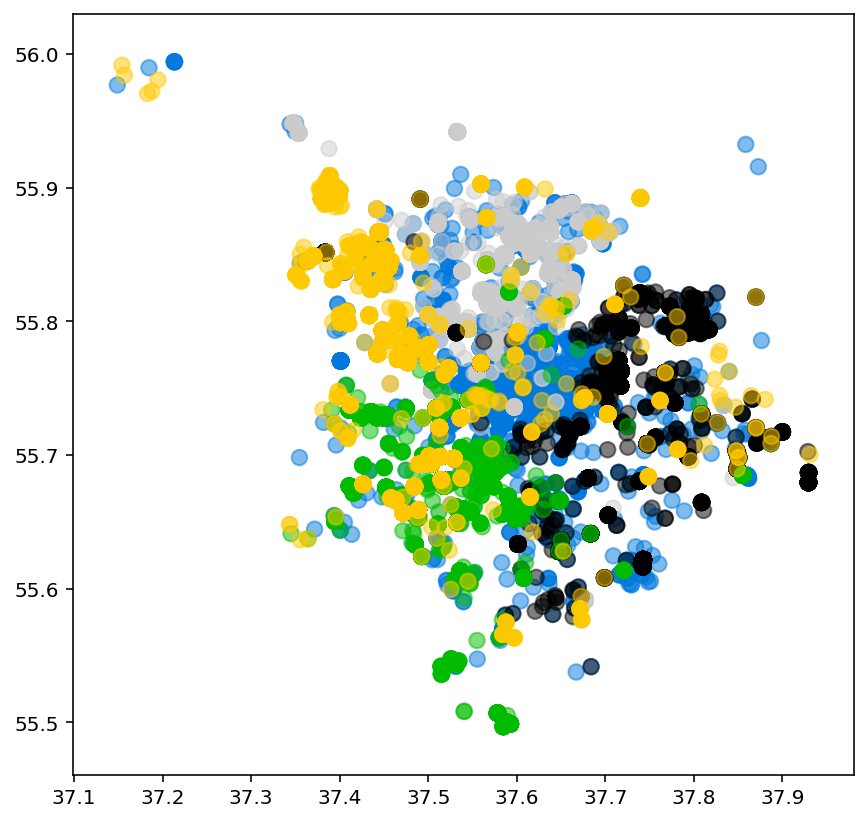

In [51]:
rcParams['figure.figsize'] = (7,7)
    
plt.scatter(comment_negative_without_votes.x, comment_negative_without_votes.y, c=n_negative_clust, alpha=0.5, cmap='nipy_spectral', s=60)

In [ ]:
# использованные методы кластеризации, либо заданные параметры не дали достаточно четкой кластеризации
# очевидно, что необходимо продолжить подбор гиперпараметров либо методик для более качествественного проведения 
# работы по кластеризации датасета 